In [1]:
# 就是抑制不是极大值的元素，可以理解为局部最大搜索。
'''
1> 根据检测框的置信度得分进行降序排序，选取分数最高的检测框A，
2> 分别计算检测框A与相邻检测框的重叠度IOU，对大于阈值的检测框得分直接置零，也就是舍去；并标记将检测框A保留下来，
3> 重复这个过程，找到所有被保留下来的检测框
'''
import numpy as np

def nms_cpu(dets,iou_thres):
    # 计算交集和并集，准备计算IOU
    x1 = dets[:,0]   # 二维的变成一维的了
    y1 = dets[:,1]
    x2 = dets[:,2]
    y2 = dets[:,3]
    scores = dets[:,4] 

    areas = (x2-x1+1)*(y2-y1+1)  # +1 是为了避免一些小数计算
    # print(areas) 
    keep = [] # 定义一个列表，用来存放NMS后剩余的方框  
    index = scores.argsort()[::-1] # 取出分数从大到小排列的索引 
    print('index:',index)
    
    # index
    while index.size>0:
        # 取出第一个方框和其他方框进行比对，看又没有
        i = index[0]
        keep.append(i) # keep先保留的是索引值，不是具体的分数
        
        # IOU计算
        x_l = np.maximum(x1[i],x1[index[1:]])   # 会减少一个框坐标
        y_l = np.maximum(y1[i], y1[index[1:]])  # 当index只有一个值的时候，index[1]会报错说index out of range，而index[1:]会是[]，不报错
        x_r = np.minimum(x2[i],x2[index[1:]])
        y_r = np.maximum(y2[i], y2[index[1:]])
        # 注意，如果两个方框相交，计算为正，不相交计算为负,负的设置为0
        h = np.maximum(0,y_r-y_l+1)
        w = np.maximum(0,x_r-x_l+1)
        
        # 计算交集
        intersection = h*w
        union = areas[i]+areas[index[1:]]-intersection
        ious = intersection/union+1e-8   # 1e-8考虑分母可能为0的情况
        
        # 把iou值大于所给的阈值的框给筛选掉
        idx = np.where(ious<=iou_thres)[0]  # 只有条件 (condition)，没有x和y，则输出满足条件 (即非0) 元素的坐标,
        # 把留下的框再次进行NMS操作     # 坐标以tuple的形式给出,通常原数组有多少维，输出的tuple中就包含几个数组，分别对应符合条件元素的各维坐标。
        index = index[idx + 1]
    return keep

boxes = np.array([[100, 100, 210, 210, 0.72],
                  [250, 250, 420, 420, 0.8],
                  [220, 220, 320, 330, 0.92],
                  [200, 210, 300, 300, 0.81],
                  [220, 230, 315, 340, 0.9]])
keep = nms_cpu(boxes,0.6)
print(keep)

index: [2 4 3 1 0]
[2, 1, 0]


[0.72 0.8  0.92 0.81 0.9 ]
[0.92 0.8  0.72]


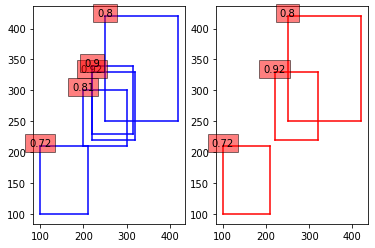

In [2]:
# 画图展示过程
import matplotlib.pyplot as plt
def draw_boxes(boxes,color):
    x1 = boxes[:,0]   # 二维的变成一维的了
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    s = boxes[:,4]
    print(s)
    plt.plot([x1,x1],[y1,y2],color)
    plt.plot([x1,x2],[y1,y1],color)
    plt.plot([x1,x2],[y2,y2],color)
    plt.plot([x2,x2],[y1,y2],color)
    for i in range(len(s)):
        plt.text(float(x1[i]), float(y2[i]), str(round(s[i],3)),ha='center', fontdict=None,bbox=dict(facecolor='red', alpha=0.5))

plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
plt.sca(ax1)
draw_boxes(boxes,'b')

plt.sca(ax2)
draw_boxes(boxes[keep],'r')
plt.show()

[[100.   100.   210.   210.     0.72]
 [250.   250.   420.   420.     0.8 ]
 [220.   220.   320.   330.     0.92]
 [200.   210.   300.   300.     0.81]
 [220.   230.   315.   340.     0.9 ]]
index: [2 4 3 1 0]
[4 3 2 1]
[1 2 3]
[1 2]
[1]
[[100.   100.   210.   210.     0.72]
 [250.   250.   420.   420.     0.8 ]
 [220.   220.   320.   330.     0.92]
 [200.   210.   300.   300.     0.81]
 [220.   230.   315.   340.     0.9 ]]
[0.72       0.55379662 0.92       0.19603741 0.0274526 ]
[0.92       0.72       0.55379662 0.19603741]


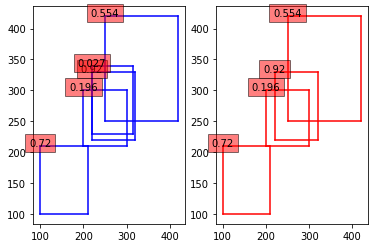

In [3]:
# soft nms ，仅仅是加了个惩罚项
'''
1> 根据检测框的置信度得分进行降序排序，选取分数最高的检测框A，
2> 分别计算检测框与相邻检测框的重叠度IOU，对大于阈值的检测框设置一个惩罚函数，降低这些检测框的置信度得分
3> 重复这个过程，找到所有被保留下来的检测框
'''
def py_cpu_softnms(dets,iou_thres,score_thres,sigma=0.5,method=1):
    # 计算交集和并集，准备计算IOU
    x1 = dets[:,0]   # 二维的变成一维的了
    y1 = dets[:,1]
    x2 = dets[:,2]
    y2 = dets[:,3]
    scores = dets[:,4] # 没有新开辟

    areas = (x2-x1+1)*(y2-y1+1)  # +1 是为了避免一些小数计算
    # print(areas) 
    keep = [] # 定义一个列表，用来存放NMS后剩余的方框  
    index = scores.argsort()[::-1] # 取出分数从大到小排列的索引 
    print('index:',index)
    
    # index
    while index.size>0:
        # 取出第一个方框和其他方框进行比对，看又没有
        i = index[0]
        keep.append(i) # keep先保留的是索引值，不是具体的分数
        
        # IOU计算
        x_l = np.maximum(x1[i],x1[index[1:]])   # 会减少一个框坐标
        y_l = np.maximum(y1[i], y1[index[1:]])  # 当order只有一个值的时候，order[1]会报错说index out of range，而order[1:]会是[]，不报错
        x_r = np.minimum(x2[i],x2[index[1:]])
        y_r = np.maximum(y2[i], y2[index[1:]])
        # 注意，如果两个方框相交，计算为正，不相交计算为负,负的设置为0
        h = np.maximum(0,y_r-y_l+1)
        w = np.maximum(0,x_r-x_l+1)
        
        # 计算交集
        intersection = h*w
        union = areas[i]+areas[index[1:]]-intersection
        ious = intersection/union+1e-8   # 1e-8考虑分母可能为0的情况
        
        # 不同的地方
        if method==0:  # 线性惩罚
            weights = np.ones(ious.shape)
            weights[ious>=iou_thres] = weights[ious>=iou_thres]-ious[ious>=iou_thres] 
        elif method==1:
            weights = np.exp(-ious*ious/sigma)
            
        # 更新分数
        scores[index[1:]] *= weights
        # 更新索引
        update_index = scores[index[1:]].argsort()[::-1]+ 1 # 因为是在order里排序，所以后面再取索引时，到原来的order里取就行了
        print(update_index)
        index = index[update_index]   # 取索引时，到原来的order里取
        # 这里不同的是用置信度分数作为筛选的依据了
        keep_idx = np.where(scores[index]>score_thres)[0]
        
        index = index[keep_idx]
    return keep

# !!! 这样出入boxes会在函数里改变里面scores的值，返回后一样改变了值
#keep_sf = py_cpu_softnms(boxes,iou_thres=0.5,score_thres=0.3,sigma=0.5,method=1)
box1 = boxes.copy()
print(boxes)
keep_sf = py_cpu_softnms(box1,iou_thres=0.5,score_thres=0.1,sigma=0.5,method=1)
print(boxes)
# 画图
plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
plt.sca(ax1)
draw_boxes(box1,'b')
plt.sca(ax2)
draw_boxes(box1[keep_sf],'r')
plt.show()

wboxes: [[220.         224.94504929 317.52746582 334.94503021]
 [200.         210.         300.         300.        ]
 [250.         250.         420.         420.        ]
 [100.         100.         210.         210.        ]] 
 wscores: [0.91000003 0.81       0.8        0.72      ] 
 wlabels [0. 0. 0. 0.]
[0.72 0.8  0.92 0.81 0.9 ]
[0.91000003 0.81       0.8        0.72      ]


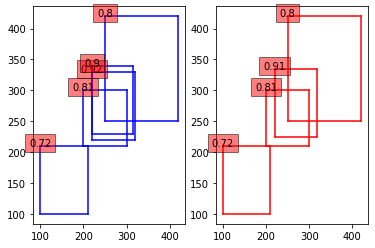

In [6]:
# wbf
from ensemble_boxes import *
def run_wbf(boxes, scores, image_size=640, iou_thr=0.5, skip_box_thr=0.7, weights=None):
    labels = [np.zeros(score.shape[0]) for score in scores]
    #labels = [np.zeros(scores.shape[0]) for _ in range(len(scores))]
    boxes = [box/(image_size) for box in boxes]
    scores = [score for score in scores]
    boxes, scores, labels = weighted_boxes_fusion(boxes, scores, labels, weights=None, iou_thr=iou_thr, skip_box_thr=skip_box_thr)
    boxes = boxes*(image_size)
    return boxes, scores, labels

box = boxes[:,:4]
box = np.expand_dims(box,axis=0)
scores = boxes[:,4]
scores = np.expand_dims(scores,axis=0)
wboxes, wscores, wlabels = run_wbf(box,scores)
print('wboxes:',wboxes,'\n','wscores:',wscores,'\n', 'wlabels',wlabels)
# 画图
def draw_boxes1(boxes,scores,color):
    x1 = boxes[:,0]   # 二维的变成一维的了
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]
    s = scores
    print(s)
    plt.plot([x1,x1],[y1,y2],color)
    plt.plot([x1,x2],[y1,y1],color)
    plt.plot([x1,x2],[y2,y2],color)
    plt.plot([x2,x2],[y1,y2],color)
    for i in range(len(s)):
        plt.text(float(x1[i]), float(y2[i]), str(round(s[i],3)),ha='center', fontdict=None,bbox=dict(facecolor='red', alpha=0.5))



plt.figure()
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
plt.sca(ax1)
draw_boxes1(boxes,boxes[:,4],'b')
plt.sca(ax2)
draw_boxes1(wboxes,wscores,'r')
plt.show()

In [ ]:
help(copy.deepcopy)